<h1>GOAL 3: Add More Features to the Data set</h1>

In [8]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [3]:
df = pd.read_csv('acetylcholinesterase_bioactivity_data_3class.csv')

<h2>Add More Lipinski Features</h2>

In an attempt to improve the predictions of druglikeness, the rules have many variants and extensions. <br>
For example:
<ul>
    <li>10 or fewer rotatable bonds</li>
    <li>the fewer aromatic rings contained in an oral drug candidate, the more developable that candidate is probably to be</li>
</ul>

https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five
<br>
https://www.sciencedirect.com/science/article/abs/pii/S1359644609002785

In [4]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_NumAromaticRings = Descriptors.NumAromaticRings(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_NumAromaticRings,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["NumAromaticRings", "NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [9]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,NumAromaticRings,NumRotatableBonds
0,3,6
1,2,4
2,3,4
3,2,3
4,2,3
...,...,...
4690,2,7
4691,2,7
4692,2,7
4693,2,8


In [10]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined.to_csv('acetylcholinesterase_bioactivity_data_expanded_3class.csv', index=False)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors,NumAromaticRings,NumRotatableBonds
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.80320,0.0,6.0,3,6
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.55460,0.0,5.0,2,4
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.35740,0.0,5.0,3,4
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.70690,0.0,5.0,2,3
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.09530,0.0,6.0,2,3
...,...,...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate,511.150,7.07230,2.0,3.0,2,7
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate,511.150,7.07230,2.0,3.0,2,7
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate,555.601,7.18140,2.0,3.0,2,7
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate,521.702,6.32710,2.0,5.0,2,8


In [34]:
lipinski_3class = df_combined.drop(columns=['molecule_chembl_id', 'canonical_smiles', 'standard_value'], axis=1)
lipinski_3class.head()

,class,MW,LogP,NumHDonors,NumHAcceptors,NumAromaticRings,NumRotatableBonds
0,active,312.325,2.8032,0.0,6.0,3,6
1,active,376.913,4.5546,0.0,5.0,2,4
2,inactive,426.851,5.3574,0.0,5.0,3,4
3,active,404.845,4.7069,0.0,5.0,2,3
4,active,346.334,3.0953,0.0,6.0,2,3


<h2>Predict LogS</h2>

<h3>LogS</h3>

Two physicochemical parameters are considered to have the most profound influence on drug-like properties of a molecule.
<ul>
    <li>aqueous solubility (logS)</li>
    <li>hydrophobicity</li>
</ul>
I will focus on aqueous solubility (logS) at this stage. Log S plays a crutial role in drug delivery since accurate activity measurements can be obtained only if the substance is sufficiently soluble.

To measure aqueous solubility of a substance, we need to know the crystal packing energy, cavitation energy and the solvation energy. Since we do not have the tools to measure them nor a data set (rdkit does not provide logS method), I will let the machine learning algorithm to predict LogS.

It is well known that it is hard to determine the solubility and also predict it. So I will use a different data set to do the prediction. If the result is satisfiable and relable, I will use the same approach to pridict the logS for the given data set. <br>
[Predicting Aqueous Solubility - It's harder than it looks by Pat Walters](https://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html)

In [12]:
df = pd.read_csv('../Downloads/delaney-processed.csv')
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [13]:
df.rename(columns={'measured log solubility in mols per litre': 'LogS'}, inplace=True)

df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

print(type(df['mol'][0]))
df.head()

<class 'rdkit.Chem.rdchem.Mol'>


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,LogS,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f851b964fa0>
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f851b964d60>
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f851b964d00>
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7f851b964f40>
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7f851b97c280>


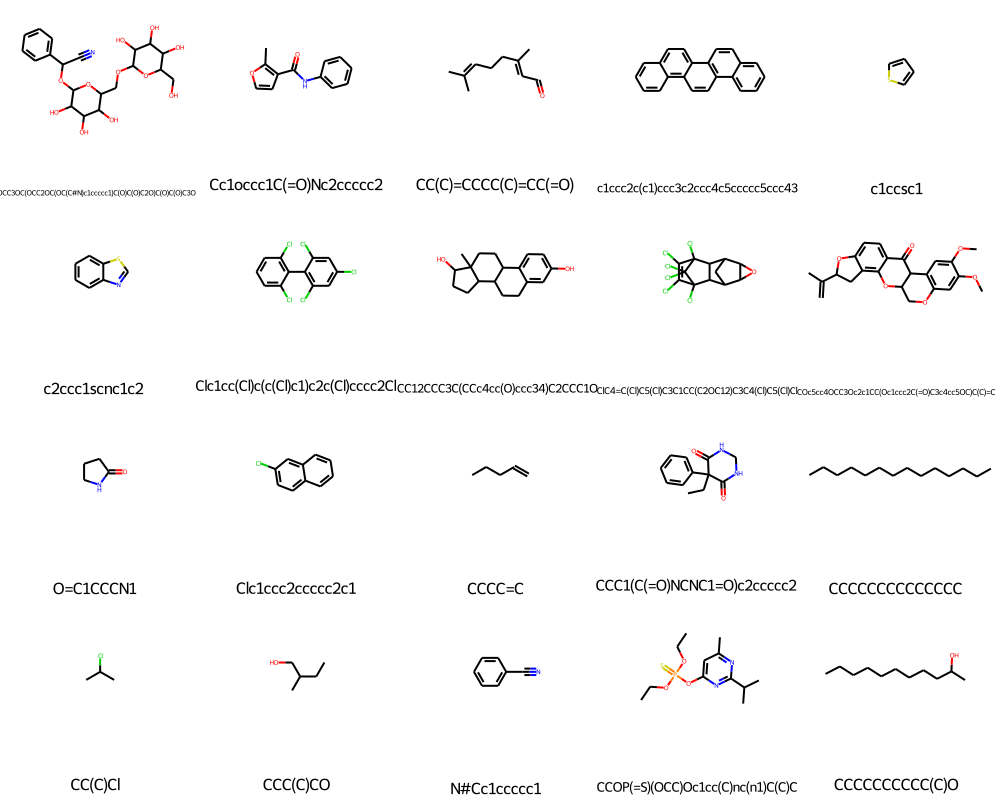

In [14]:
from rdkit.Chem import Draw
mols = df['mol'][:20]

Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=False, legends=list(df['smiles'][:20].values))

In [15]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,LogS,smiles,mol,num_of_atoms,num_of_heavy_atoms
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd160>,59,32
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd880>,26,15
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd820>,27,11
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd100>,36,22
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd9a0>,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x7f851b8ca400>,8,7
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f851b8ca460>,27,14
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7f851b8ca4c0>,27,12
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f851b8ca520>,17,5


In [16]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

/home/student/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


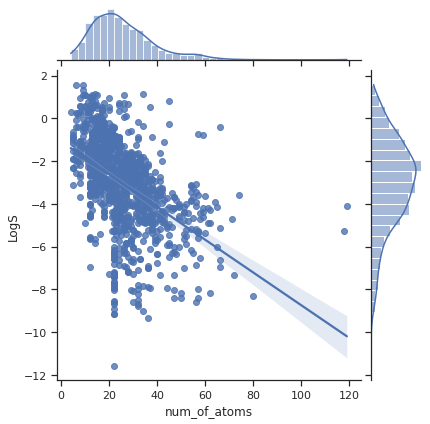

In [18]:
%matplotlib inline

x = df['num_of_atoms']
y = df['LogS']

sns.jointplot(x, y,
               kind='reg')


/home/student/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


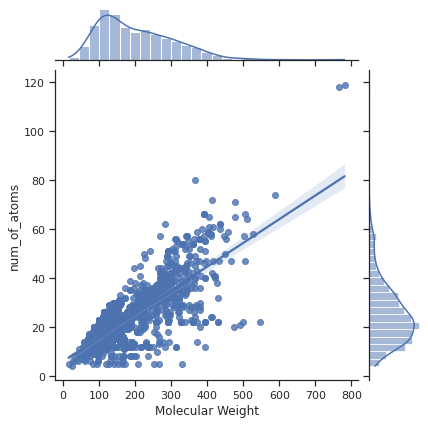

In [19]:
x = df['Molecular Weight']
y = df['num_of_atoms']

sns.jointplot(x, y,
               kind='reg')

/home/student/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


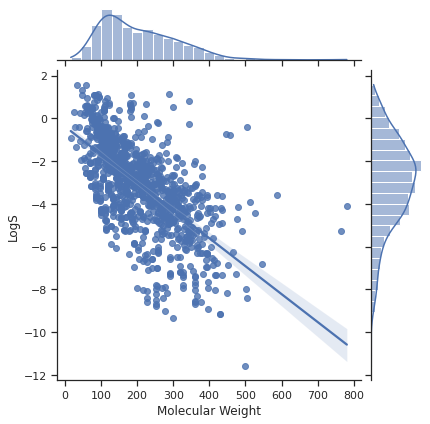

In [21]:
x = df['Molecular Weight']
y = df['LogS']

sns.jointplot(x, y,
               kind='reg')

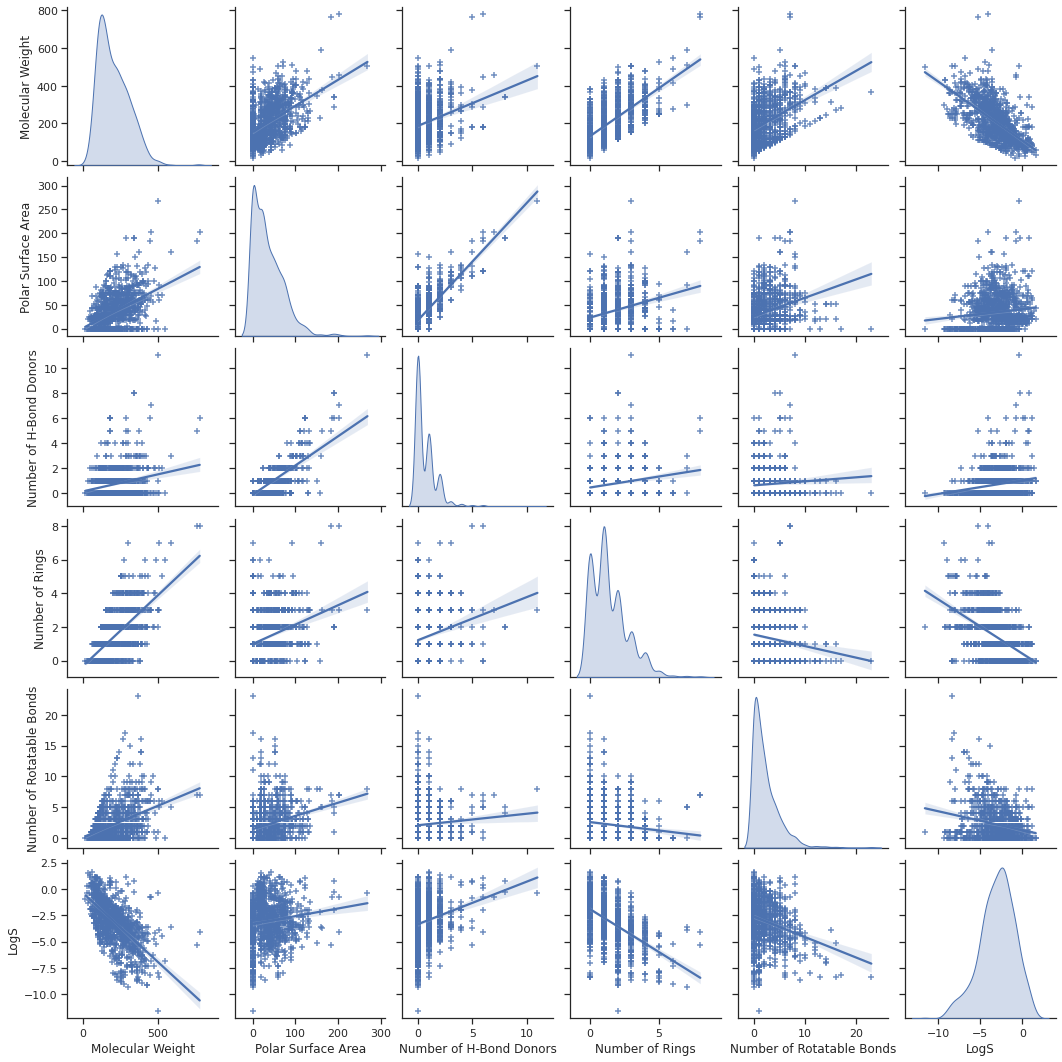

In [22]:
sns.pairplot(df[['Molecular Weight','Polar Surface Area','Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'LogS']],
            diag_kind='kde', kind='reg', markers='+')

In [23]:
from rdkit.Chem.Draw import rdMolDraw2D

amigdalin=df['mol'][0]

d = rdMolDraw2D.MolDraw2DCairo(600, 550)
d.drawOptions().addAtomIndices = True

d.DrawMolecule(amigdalin)

d.FinishDrawing()
d.WriteDrawingText('atom_annotation_1.png') 

file:///home/student/MLproject_chemistry/atom_annotation_1.png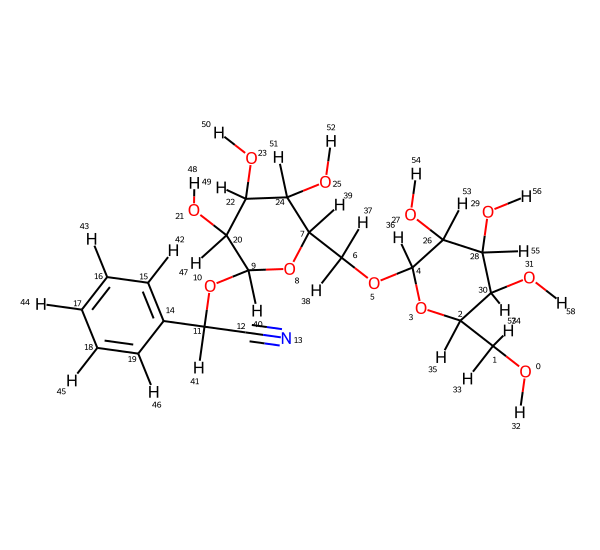

In [24]:
c_patt = Chem.MolFromSmiles('C')
match = df['mol'][0].GetSubstructMatches(c_patt)

In [25]:
from rdkit.Chem.Draw import IPythonConsole

print(match)
len(match)

((1,), (2,), (4,), (6,), (7,), (9,), (11,), (12,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (22,), (24,), (26,), (28,), (30,))


20

In [26]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

In [27]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,LogS,smiles,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd160>,59,32,20,11,1,0
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd880>,26,15,12,2,1,0
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd820>,27,11,10,1,0,0
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd100>,36,22,22,0,0,0
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7f851b7bd9a0>,9,5,4,0,0,0


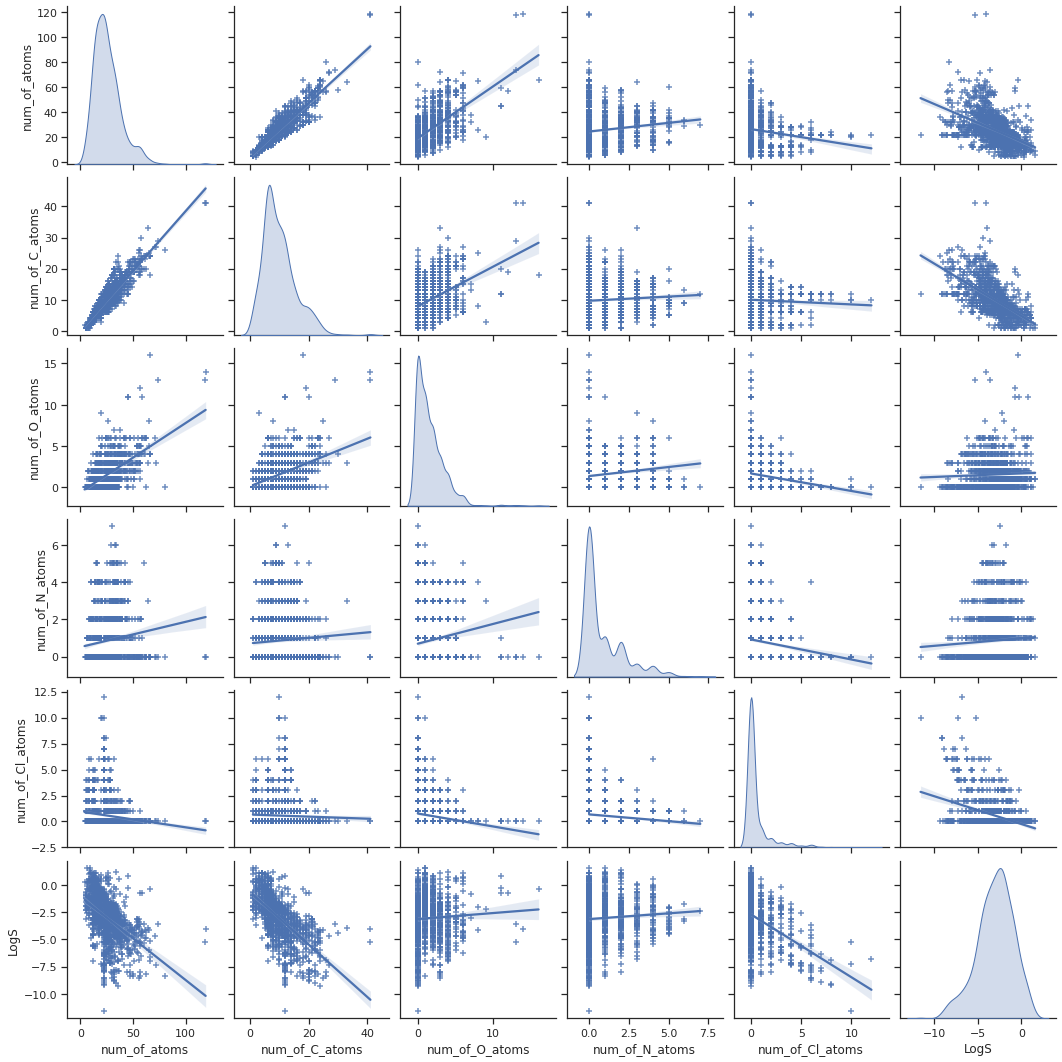

In [29]:
sns.pairplot(df[['num_of_atoms', 'num_of_C_atoms', 'num_of_O_atoms', 
             'num_of_N_atoms', 'num_of_Cl_atoms','LogS']],
            diag_kind='kde', kind='reg', markers='+')
plt.show()
                                      

In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

#Leave only features columns
train_df = df.drop(columns=['Compound ID','ESOL predicted log solubility in mols per litre', 'smiles', 'mol', 'LogS'])
y = df['LogS'].values

print(train_df.columns)

#Perform a train-test split. We'll use 10% of the data to evaluate the model while training on 90%

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.2, random_state=1)


Index(['Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('log solubility')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse, 4))

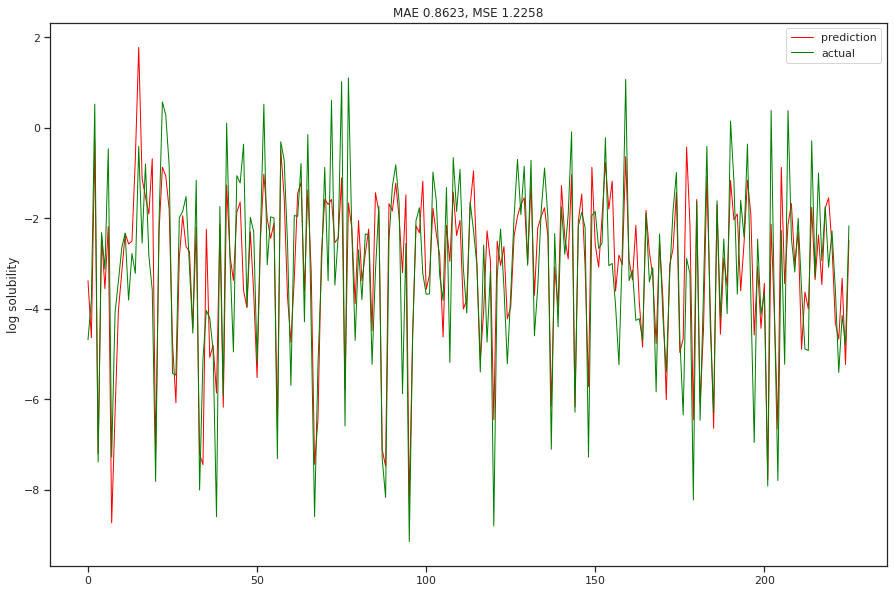

MAE score: 0.8623
MSE score: 1.2258


In [32]:
#Train the model
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
#Evaluate results
evaluation(ridge, X_test, y_test)

The result is not relable and the error cannot be ignored. There are many tools and algorithms introduced to predict logS more accurately.
However, it involves Deep Learning (Neural network) technics and artificial intelligence (AI) prediction tools, that are not the scope of this project. 

Therefore, I will not take LogS into account. Let's train the model from the previous notebook with newly added features.

<h2>Train and Test the Model</h2>

In [45]:
lipinski_3class['class'].replace({'inactive': -1, 'intermediate': 0, 'active': 1}, inplace=True)

In [46]:
X = lipinski_3class.drop('class', axis=1)
y = lipinski_3class['class']

array([[<AxesSubplot:xlabel='class', ylabel='class'>,
        <AxesSubplot:xlabel='NumAromaticRings', ylabel='class'>,
        <AxesSubplot:xlabel='NumRotatableBonds', ylabel='class'>],
       [<AxesSubplot:xlabel='class', ylabel='NumAromaticRings'>,
        <AxesSubplot:xlabel='NumAromaticRings', ylabel='NumAromaticRings'>,
        <AxesSubplot:xlabel='NumRotatableBonds', ylabel='NumAromaticRings'>],
       [<AxesSubplot:xlabel='class', ylabel='NumRotatableBonds'>,
        <AxesSubplot:xlabel='NumAromaticRings', ylabel='NumRotatableBonds'>,
        <AxesSubplot:xlabel='NumRotatableBonds', ylabel='NumRotatableBonds'>]],
      dtype=object)

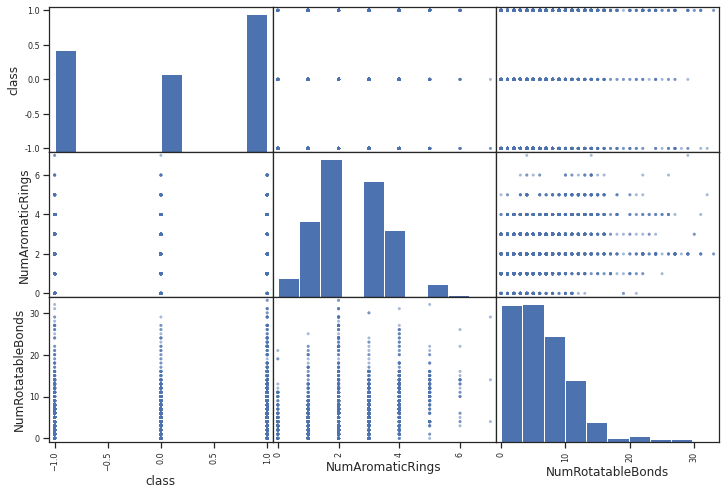

In [73]:
from pandas.plotting import scatter_matrix

attributes = ['class', 'NumAromaticRings', 'NumRotatableBonds']
scatter_matrix(lipinski_3class[attributes], figsize=(12, 8))

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

In [48]:
# simplify the problem
y_train_activate = (y_train == 1)
y_test_activate = (y_test == 1)
y_train_activate

2314    False
3064     True
1824    False
1458     True
40      False
        ...  
2612    False
3130    False
4631    False
2756    False
345      True
Name: class, Length: 3756, dtype: bool

In [50]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

randForest_clf = RandomForestClassifier(random_state=42)
y_train_pred = cross_val_predict(randForest_clf, X_train, y_train_activate, cv=3)
print('predicted:', y_train_pred)
print('actual:', y_train_activate.tolist)

predicted: [False  True False ... False False  True]
actual: <bound method IndexOpsMixin.tolist of 2314    False
3064     True
1824    False
1458     True
40      False
        ...  
2612    False
3130    False
4631    False
2756    False
345      True
Name: class, Length: 3756, dtype: bool>


In [51]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_activate, y_train_pred))
print(recall_score(y_train_activate, y_train_pred))

0.7357750163505559
0.6897608828939301


In [52]:
from sklearn.metrics import f1_score
f1_score(y_train_activate, y_train_pred)

0.7120253164556962

In [53]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_activate, cv=3, method='predict_proba')

In [54]:
from sklearn.metrics import roc_curve

y_scores_forest = y_probas_forest[:, 1] # scores = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_activate, y_scores_forest)

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate(recall)', fontsize=16)
    plt.axis([0, 1, 0, 1])

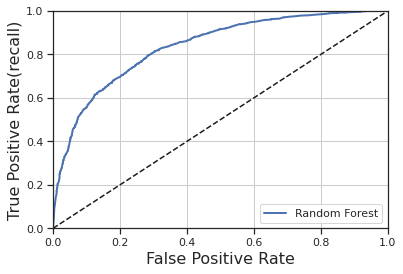

In [56]:
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
   {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 7, 10, 15]}
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 7, 10, 15],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='neg_mean_squared_error')

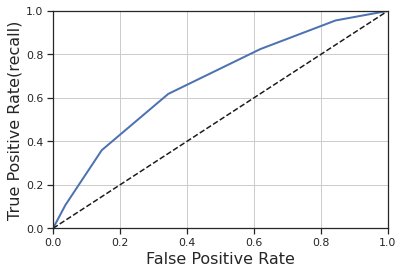

In [62]:
y_probas_knn = cross_val_predict(knn_clf, X_train, y_train_activate, cv=3, method='predict_proba')
y_scores_knn = y_probas_knn[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train_activate, y_scores_knn)
plot_roc_curve(fpr_knn, tpr_knn, label='KNN')

In [57]:
forest_clf.fit(X_train, y_train_activate)

RandomForestClassifier(random_state=42)

In [58]:
y_pred = forest_clf.predict(X_test)
print(precision_score(y_test_activate, y_pred))
print(recall_score(y_test_activate, y_pred))
f1_score(y_test_activate, y_pred)

0.7210526315789474
0.6715686274509803


0.6954314720812182

<h2>Conclusion</h2>

To predict a molecule's drug-likeness more precisely, it requires more complex models and features.
A model that is trained using shallow learning algorithms tend to be under-fitting. <br>
However, we are still able to find underlying relationships among Lipinski features and druglikeness. <br>
Also, it was possible to improve the machine's prediciton ability by adding more features.
It shows that the prediction can be enhanced even further.

<h2>Next Tasks</h2>

<ol>
    <li>Go back to fp: what does a fp tell us regarding drug-likeness prediction?</li>
    <li>dive deeper into LogP</li>
</ol>